# 基于HMM的地图匹配程序

#本项目实现了一个基于隐藏马尔可夫模型（HMM）的地图匹配算法，将GPS观测点（例如，红点）匹配到给定的公交路线（GPS轨迹）上。该程序使用Python编写，并利用了NumPy、Matplotlib等库进行计算和可视化。


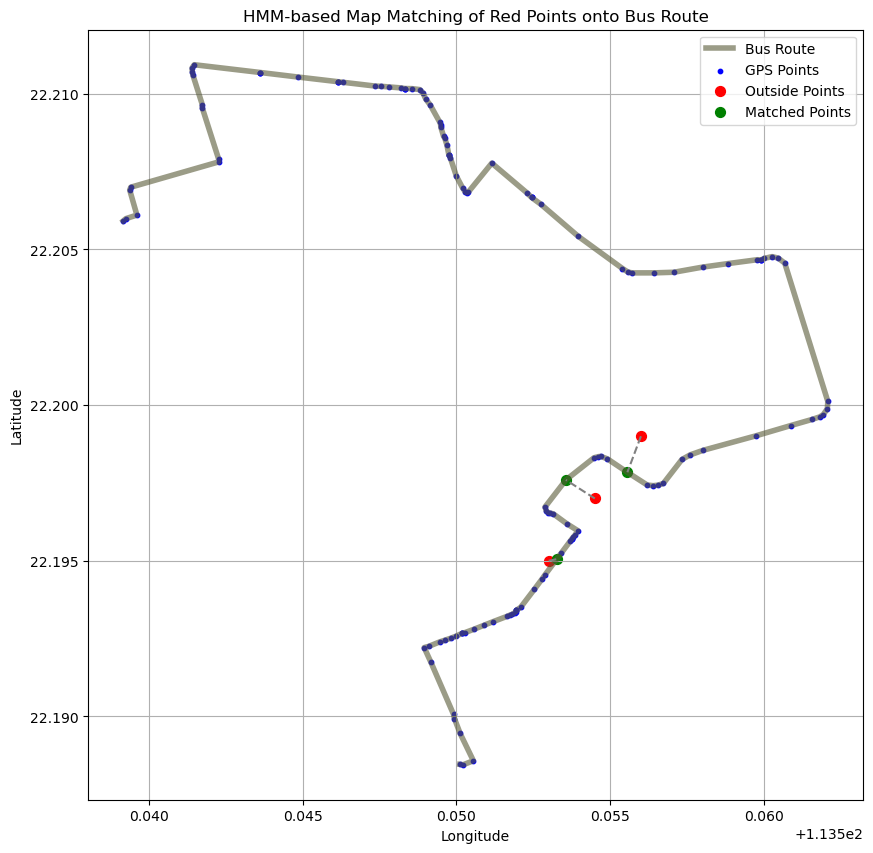

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Helper function to compute Haversine distance between two GPS points
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in meters between two points
    on the earth (specified in decimal degrees)
    """
    R = 6371000  # Radius of earth in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    meters = R * c    # Output distance in meters
    return meters

# Bus route coordinates (more_coordinates)
more_coordinates = [
    ['113.55011000', '22.18846100'],
    ['113.55022000', '22.18844800'],
    ['113.55055000', '22.18857600'],
    ['113.55012000', '22.18945100'],
    ['113.54993400', '22.18993000'],
    ['113.54990400', '22.19006700'],
    ['113.54916400', '22.19175000'],
    ['113.54895000', '22.19221100'],
    ['113.5491', '22.19225100'],
    ['113.54945000', '22.19239200'],
    ['113.54963000', '22.19245000'],
    ['113.54981000', '22.19251000'],
    ['113.54999500', '22.19258100'],
    ['113.55018000', '22.19267000'],
    ['113.55018000', '22.19267000'],
    ['113.55018000', '22.19267000'],
    ['113.55027000', '22.19269000'],
    ['113.55057500', '22.19280200'],
    ['113.5509', '22.19293000'],
    ['113.5512', '22.19304700'],
    ['113.55165000', '22.19321600'],
    ['113.55173500', '22.19325300'],
    ['113.55181000', '22.19328000'],
    ['113.55189500', '22.19333000'],
    ['113.55194000', '22.19336700'],
    ['113.55195000', '22.19341000'],
    ['113.55195000', '22.19341000'],
    ['113.55195000', '22.19341000'],
    ['113.55208600', '22.19350200'],
    ['113.55253000', '22.19407700'],
    ['113.55278000', '22.19440800'],
    ['113.55287000', '22.19453400'],
    ['113.55326000', '22.19505000'],
    ['113.55341000', '22.19524400'],
    ['113.5537', '22.19562700'],
    ['113.55375000', '22.19569800'],
    ['113.55375000', '22.19569800'],
    ['113.55379500', '22.19575500'],
    ['113.55385000', '22.19581600'],
    ['113.55395000', '22.19596500'],
    ['113.55358000', '22.19619600'],
    ['113.55315000', '22.19650700'],
    ['113.55305000', '22.19653100'],
    ['113.55298000', '22.19654800'],
    ['113.55292000', '22.19660600'],
    ['113.55288000', '22.19672600'],
    ['113.55356000', '22.19759600'],
    ['113.55447400', '22.19830900'],
    ['113.55462000', '22.19834500'],
    ['113.55469500', '22.19835300'],
    ['113.55491000', '22.19827300'],
    ['113.55556000', '22.19784200'],
    ['113.55620600', '22.19743300'],
    ['113.55640400', '22.19741200'],
    ['113.55656400', '22.19743000'],
    ['113.55673000', '22.19748300'],
    ['113.55733500', '22.19825400'],
    ['113.5576', '22.1984'],
    ['113.55802000', '22.19854700'],
    ['113.55973000', '22.19901000'],
    ['113.56087500', '22.19934300'],
    ['113.56157000', '22.19954000'],
    ['113.56182000', '22.19962300'],
    ['113.56193500', '22.19969700'],
    ['113.56206500', '22.19988300'],
    ['113.56208000', '22.20012000'],
    ['113.56068000', '22.20456100'],
    ['113.56047000', '22.20472000'],
    ['113.56027000', '22.20477000'],
    ['113.56002000', '22.20471400'],
    ['113.55991000', '22.20466600'],
    ['113.55991000', '22.20466600'],
    ['113.55991000', '22.20466600'],
    ['113.55978400', '22.20467000'],
    ['113.55882000', '22.20454400'],
    ['113.55801000', '22.20443300'],
    ['113.55707600', '22.20426800'],
    ['113.55643000', '22.20424800'],
    ['113.55572000', '22.20424700'],
    ['113.55558000', '22.20427300'],
    ['113.5554', '22.20438800'],
    ['113.55396000', '22.20542300'],
    ['113.55275000', '22.20644800'],
    ['113.55244400', '22.20666900'],
    ['113.55244400', '22.20666900'],
    ['113.55244400', '22.20666900'],
    ['113.5523', '22.20681200'],
    ['113.55115000', '22.20777300'],
    ['113.55038500', '22.20684200'],
    ['113.55034000', '22.20682100'],
    ['113.55028500', '22.20685200'],
    ['113.5502', '22.20697400'],
    ['113.54999500', '22.20736000'],
    ['113.54980500', '22.20793000'],
    ['113.54975000', '22.20805000'],
    ['113.54975000', '22.20805000'],
    ['113.54975000', '22.20805000'],
    ['113.54969000', '22.20835100'],
    ['113.54962000', '22.20857400'],
    ['113.54958000', '22.20863500'],
    ['113.54949000', '22.20893300'],
    ['113.54948400', '22.20901300'],
    ['113.54946000', '22.20908200'],
    ['113.54914000', '22.20965000'],
    ['113.5490', '22.20983100'],
    ['113.54891000', '22.21002800'],
    ['113.54880500', '22.21013500'],
    ['113.54856000', '22.21016500'],
    ['113.54831000', '22.21017000'],
    ['113.54831000', '22.21017000'],
    ['113.54831000', '22.21017000'],
    ['113.54821000', '22.21018800'],
    ['113.54782000', '22.21022000'],
    ['113.54755000', '22.21024100'],
    ['113.54735000', '22.21024900'],
    ['113.54629500', '22.21037100'],
    ['113.54615000', '22.21039000'],
    ['113.54615000', '22.21039000'],
    ['113.54615000', '22.21039000'],
    ['113.54486000', '22.21053700'],
    ['113.54362000', '22.21068400'],
    ['113.54362000', '22.21068400'],
    ['113.54362000', '22.21068400'],
    ['113.54147000', '22.21093400'],
    ['113.5414', '22.21083300'],
    ['113.54140500', '22.21070500'],
    ['113.54143000', '22.21058800'],
    ['113.54173000', '22.20965600'],
    ['113.54173000', '22.20955000'],
    ['113.54226000', '22.20791200'],
    ['113.54227400', '22.20781500'],
    ['113.53940600', '22.2070'],
    ['113.53937000', '22.20691100'],
    ['113.53960400', '22.20610400'],
    ['113.53924600', '22.20599000'],
    ['113.53916000', '22.20591700']
]

# Convert bus route coordinates to float and store as (longitude, latitude) tuples
route_points = [(float(coord[0]), float(coord[1])) for coord in more_coordinates]

# Outside red points
outside_points = [
    ['113.55300000', '22.19500000'],
    ['113.55450000', '22.19700000'],
    ['113.55600000', '22.19900000']
]

# Convert outside points to float and store as (longitude, latitude) tuples
observations = [(float(point[0]), float(point[1])) for point in outside_points]

# Parameters for HMM
sigma_z = 10  # Standard deviation of GPS error in meters (adjust as needed)
beta = 5      # Transition probability parameter (adjust as needed)

# Candidate Generation: For each observation, find candidate points on the route within a radius
def generate_candidates(observations, route_points, radius=50):
    """
    For each observation, generate candidate points from the route within the specified radius.
    """
    candidates = []
    for obs in observations:
        candidate_points = []
        for idx, rp in enumerate(route_points):
            distance = haversine(obs[0], obs[1], rp[0], rp[1])
            if distance <= radius:
                candidate_points.append({'point': rp, 'index': idx})
        # If no candidate found within radius, consider the closest point
        if not candidate_points:
            min_distance = float('inf')
            closest_point = None
            closest_idx = -1
            for idx, rp in enumerate(route_points):
                distance = haversine(obs[0], obs[1], rp[0], rp[1])
                if distance < min_distance:
                    min_distance = distance
                    closest_point = rp
                    closest_idx = idx
            candidate_points.append({'point': closest_point, 'index': closest_idx})
        candidates.append(candidate_points)
    return candidates

# Compute Emission Probabilities
def compute_emission_probabilities(observations, candidates, sigma_z):
    """
    Compute emission probabilities for each candidate point.
    """
    emission_probabilities = []
    for obs, candidate_list in zip(observations, candidates):
        emis_probs = []
        for candidate in candidate_list:
            distance = haversine(obs[0], obs[1], candidate['point'][0], candidate['point'][1])
            # Using Gaussian distribution for emission probability
            prob = (1 / (sigma_z * math.sqrt(2 * math.pi))) * math.exp(- (distance ** 2) / (2 * sigma_z ** 2))
            emis_probs.append({'candidate': candidate, 'prob': prob})
        emission_probabilities.append(emis_probs)
    return emission_probabilities

# Compute Transition Probabilities
def compute_transition_probabilities(candidates, route_points, beta):
    """
    Compute transition probabilities between candidates of consecutive observations.
    """
    transition_probabilities = []
    for i in range(len(candidates) - 1):
        trans_probs = defaultdict(dict)
        for origin in candidates[i]:
            for destination in candidates[i + 1]:
                # Compute shortest path distance along the route (since route is a sequence, it's cumulative distance)
                idx_origin = origin['index']
                idx_destination = destination['index']
                if idx_origin <= idx_destination:
                    path_distance = 0
                    for j in range(idx_origin, idx_destination):
                        p1 = route_points[j]
                        p2 = route_points[j + 1]
                        path_distance += haversine(p1[0], p1[1], p2[0], p2[1])
                else:
                    path_distance = 0
                    for j in range(idx_origin, idx_destination, -1):
                        p1 = route_points[j]
                        p2 = route_points[j - 1]
                        path_distance += haversine(p1[0], p1[1], p2[0], p2[1])
                # Compute Euclidean distance between observations
                delta_distance = abs(path_distance)
                # Using exponential distribution for transition probability
                prob = (1 / beta) * math.exp(- delta_distance / beta)
                trans_probs[origin['index']][destination['index']] = prob
        transition_probabilities.append(trans_probs)
    return transition_probabilities

# Viterbi Algorithm
def viterbi(emission_probs, transition_probs):
    """
    Perform the Viterbi algorithm to find the most probable sequence of candidate points.
    """
    T = len(emission_probs)
    V = [{}]  # Viterbi matrix
    path = {}
    
    # Initialize base cases (t == 0)
    for candidate in emission_probs[0]:
        idx = candidate['candidate']['index']
        V[0][idx] = math.log(candidate['prob'])
        path[idx] = [candidate['candidate']['point']]
    
    # Run Viterbi for t > 0
    for t in range(1, T):
        V.append({})
        new_path = {}
        for dest_candidate in emission_probs[t]:
            dest_idx = dest_candidate['candidate']['index']
            max_prob = float('-inf')
            best_origin = None
            for origin_idx in V[t - 1]:
                if origin_idx in transition_probs[t - 1] and dest_idx in transition_probs[t - 1][origin_idx]:
                    trans_prob = transition_probs[t - 1][origin_idx][dest_idx]
                    prob = V[t - 1][origin_idx] + math.log(trans_prob) + math.log(dest_candidate['prob'])
                    if prob > max_prob:
                        max_prob = prob
                        best_origin = origin_idx
            if best_origin is not None:
                V[t][dest_idx] = max_prob
                new_path[dest_idx] = path[best_origin] + [dest_candidate['candidate']['point']]
        path = new_path
    # Find the final most probable path
    if not V[-1]:
        print("No path found")
        return []
    max_prob = max(V[-1].values())
    for idx, prob in V[-1].items():
        if prob == max_prob:
            best_path = path[idx]
            break
    return best_path

# Main execution
# 1. Generate candidates
candidates = generate_candidates(observations, route_points, radius=50)

# 2. Compute emission probabilities
emission_probs = compute_emission_probabilities(observations, candidates, sigma_z)

# 3. Compute transition probabilities
transition_probs = compute_transition_probabilities(candidates, route_points, beta)

# 4. Run Viterbi algorithm
matched_points = viterbi(emission_probs, transition_probs)

# Extract longitudes and latitudes for plotting
route_longitudes = [p[0] for p in route_points]
route_latitudes = [p[1] for p in route_points]

outside_longitudes = [p[0] for p in observations]
outside_latitudes = [p[1] for p in observations]

if matched_points:
    matched_longitudes = [p[0] for p in matched_points]
    matched_latitudes = [p[1] for p in matched_points]
else:
    matched_longitudes = []
    matched_latitudes = []

# Plot the bus route, outside points, and matched points
plt.figure(figsize=(10, 10))
plt.plot(route_longitudes, route_latitudes, color='#595A38', alpha=0.6, linewidth=4, label="Bus Route")
plt.scatter(route_longitudes, route_latitudes, color='blue', s=10, label="GPS Points")
plt.scatter(outside_longitudes, outside_latitudes, color='red', s=50, label="Outside Points")

if matched_points:
    plt.scatter(matched_longitudes, matched_latitudes, color='green', s=50, label="Matched Points")
    # Draw lines connecting outside points to their matched points
    for i in range(len(observations)):
        plt.plot([outside_longitudes[i], matched_longitudes[i]],
                 [outside_latitudes[i], matched_latitudes[i]], color='gray', linestyle='--')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("HMM-based Map Matching of Red Points onto Bus Route")
plt.legend()
plt.grid(True)
plt.show()
